# GAN simple model
A first stab at GAN models. Using data with one feature and one target. In this case chosen x^3 to be it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense 

2022-06-16 18:20:52.350157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 18:20:52.350185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def calculate(x):
    return x * x * x

In [4]:
def generate_real_samples(n):
    X1 = np.random.rand(n) - 0.5
    
    X2 = X1 * X1 * X1 
    X1 = X1.reshape(n,1)
    X2 = X2.reshape(n,1)
    
    X = np.hstack((X1,X2))
    y = np.ones((n,1))
    
    return X,y 

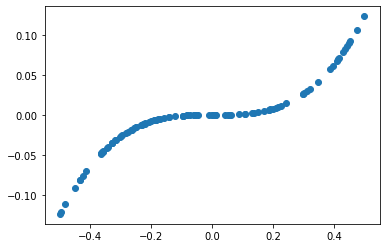

In [20]:
test_real_samples, _ = generate_real_samples(100)
plt.scatter(test_real_samples[:,0], test_real_samples[:,1])

In [21]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer = 'he_uniform',
                   input_dim=n_inputs,))
    model.add(Dense(1, activation='sigmoid',))
    model.compile(optimizer='Adam', loss='binary_crossentropy', 
                 metrics=['accuracy'],)
    return model

In [22]:
def generate_latent_points(latent_dim, n):
#   generate random numbers from the normal dist
    x_input = np.random.randn(latent_dim * n)
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [23]:
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n)
    X = generator.predict(x_input)
    y = np.zeros((n,1))
    return X,y

In [24]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        X_real, y_real = generate_real_samples(half_batch)
        
        model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(half_batch)
        
        model.train_on_batch(X_fake, y_fake)
        
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)
        

In [25]:
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform',
                   input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [26]:
def define_gan(generator, discriminator):
#     make weights in the discr not trainable, why?
    discriminator.trainable = False
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(optimizer='Adam', loss='binary_crossentropy')
    return model

In [29]:
def summarise_performance(epoch, generator, discriminator, latent_dim, n=100):
    x_real, y_real = generate_real_samples(n)
    
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    print(epoch, acc_real, acc_fake)
    
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color='blue')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [27]:
def train(g_model, d_model, gan_model, latent_dim, 
          n_epochs=10000, n_batch=128, n_eval=2000):
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        x_real, y_real = generate_real_samples(half_batch)
        
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
#         update the discriminator 
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        x_gan = generate_latent_points(latent_dim, n_batch)
#         creating inverted labels for the fake samples, why?
        y_gan = np.ones((n_batch,1))
    
        gan_model.train_on_batch(x_gan, y_gan)
        
        if (i+1) % n_eval == 0:
            summarise_performance(i, g_model, d_model, latent_dim)
        

In [30]:
latent_dim = 100

g_model = define_generator(latent_dim)

d_model = define_discriminator()

gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, latent_dim)

2022-06-16 18:28:21.854536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-16 18:28:21.854582: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-16 18:28:21.854611: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mikiu-xps13): /proc/driver/nvidia/version does not exist
2022-06-16 18:28:21.855380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 0s 7ms/step


2022-06-16 18:28:23.096686: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:23.108240: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:23.244634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:23.484676: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:28:23.696731: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 10ms/step


2022-06-16 18:28:24.243939: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:26.100622: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:26.560640: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:26.880649: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:28.574461: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:28.720439: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:29.152655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:29.400214: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:29.715808: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:30.521705: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:30.670657: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:30.688675: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 6ms/step


2022-06-16 18:28:31.149081: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 11ms/step


2022-06-16 18:28:32.806635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:32.815289: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:33.870021: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:28:34.286512: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:35.044615: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:28:35.370433: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:35.388376: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:28:36.574101: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:28:37.457982: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:37.856624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:38.192675: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:38.431989: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:38.511730: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:38.692635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:40.561805: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:40.576983: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:40.644635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:40.728697: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:40.828090: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:41.074923: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:41.863851: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:41.878295: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:42.328639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:42.412652: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:28:42.658593: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:42.964622: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:43.760414: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:45.427708: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:46.528624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:28:46.891226: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:47.216652: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:47.368628: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:47.999750: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:48.468600: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:49.335130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:49.736407: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:51.468618: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:51.622837: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:52.118233: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:52.203592: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:53.070875: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:53.388301: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:55.889021: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:56.218032: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:56.374413: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 6ms/step


2022-06-16 18:28:56.557966: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:28:56.888348: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:57.009411: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 7ms/step


2022-06-16 18:28:58.624075: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:59.152692: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:28:59.455905: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:28:59.673788: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:28:59.823984: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:00.209808: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:00.507220: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:01.559138: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:29:02.242594: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:03.192501: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:04.095586: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:04.392982: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:05.441954: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:07.515805: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:07.898339: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:08.395300: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:29:08.916373: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:09.147150: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:09.964596: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:10.264458: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:11.565103: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:13.501756: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:29:13.748879: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:13.847342: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:15.518954: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:15.589255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:15.604878: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:15.680631: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:15.688627: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:15.884412: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:16.032646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:29:16.532675: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:16.752073: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:17.136014: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:19.984873: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:20.623840: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:21.072181: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:21.723854: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:23.641099: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:23.790503: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:24.224391: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:24.658133: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:26.095976: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:27.628668: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:30.412674: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:31.696626: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:29:31.913549: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:29:34.147244: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:34.217996: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:35.083049: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:35.664357: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:36.299933: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:36.735531: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:40.819495: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:42.322075: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:45.139190: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:46.005115: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:46.156408: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:47.740695: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:49.459416: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:50.276619: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:50.343489: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:52.126973: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:29:52.561129: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:52.630040: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:52.779272: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:29:56.284110: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:29:56.432672: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:29:56.516431: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:00.579113: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:00.792676: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:01.345919: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:02.077019: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:30:02.150306: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:05.199569: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:05.783901: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:06.300739: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:07.318439: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:08.119875: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:09.953487: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:10.636744: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:11.738296: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:12.321391: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:13.086631: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:13.305292: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:16.742818: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:19.375160: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:20.026502: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:20.280620: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:20.928941: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:30:21.296225: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:30:21.394627: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:21.607105: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:23.496384: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:23.863035: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:24.614993: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:25.497495: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:28.183372: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:29.002866: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:29.799430: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:30.952010: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:32.403262: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:36.438999: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:37.523509: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:40.487918: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:40.776636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:40.993914: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:41.576186: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:41.811156: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:46.431127: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:46.639080: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:47.647956: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:48.947422: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:49.400039: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:50.419478: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:30:50.494625: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:50.999319: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:51.216633: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:30:51.233896: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:51.668733: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:30:53.699231: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:54.336417: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step
1999 0.4399999976158142 0.0
1/2 [==============>...............] - ETA: 0s

2022-06-16 18:30:57.389788: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:30:59.138963: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:02.091470: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:06.225944: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:07.261161: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:08.695860: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:10.348490: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:10.565386: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:11.064606: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:11.284322: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:11.351874: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:12.430791: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:13.229284: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:13.815599: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:14.050236: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:15.932348: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:16.152001: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:16.371412: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:16.517680: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:18.065250: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:18.151420: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:18.312474: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:19.215678: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:20.115054: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:20.329930: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:21.016334: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:22.384205: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:22.616868: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:24.169003: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:24.252632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:24.716692: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:25.687953: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:26.052643: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:26.724410: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:28.056850: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:30.352638: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:34.259700: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:35.592670: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:35.892335: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:35.961585: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:36.111049: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:37.012070: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:37.745919: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:38.612678: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:38.779774: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:39.216937: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:42.217357: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:44.903299: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:45.335075: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:31:46.134735: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:46.502220: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:47.303283: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:47.670593: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:47.820039: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:48.252324: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:48.552306: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:50.738646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:50.888330: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:51.239099: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:31:51.606762: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:51.756135: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:53.057591: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:53.656605: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:54.741965: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:54.825639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:57.077197: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:57.976907: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:31:58.995421: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:31:59.611254: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:31:59.692845: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:02.080670: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:03.397375: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:03.470680: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:04.384299: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:05.101034: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:07.203688: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:08.369255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:08.520636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:09.636509: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:09.852738: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:10.951628: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:11.733865: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:12.687520: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:13.974396: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:14.338732: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:14.555658: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:15.506768: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:16.808256: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:17.459370: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:17.610950: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:17.842488: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:18.225417: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:19.178967: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:19.609834: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:19.759812: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:20.276691: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:20.496093: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:21.176685: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:21.896618: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:21.982082: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:22.780624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:23.295545: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:25.167130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:25.897791: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:26.950089: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:27.232738: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:27.531880: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:27.682155: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:28.265114: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:28.416625: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:28.852598: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:29.379040: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:30.467611: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:30.698498: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:31.016922: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:32.034964: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:34.202834: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:34.420727: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:34.572181: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:35.224026: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:35.603292: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:35.836622: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:37.269468: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:37.724167: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:38.090613: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:38.740669: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:42.209161: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:32:42.592709: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:42.675007: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:43.976042: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:44.224643: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:44.626581: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:44.709260: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:44.877275: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:45.260931: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:45.643082: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:46.010785: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:32:47.049218: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:48.135546: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:48.599725: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:48.919341: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:49.520619: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:50.267980: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:51.402914: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:52.152284: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:53.052659: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:53.356547: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:54.187852: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:54.586485: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:54.971411: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:55.587192: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:56.276150: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:56.872624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:32:57.022071: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:32:57.175008: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:32:59.659870: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:01.008412: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:01.311169: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:02.260690: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:03.160689: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:03.843591: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:05.395024: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:05.713041: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:06.449537: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:07.063253: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:08.096645: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:09.415421: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:10.031530: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:10.484644: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:10.984640: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:11.294040: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:12.116669: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:12.335201: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:12.700925: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:13.969026: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:13.985572: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:15.018700: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:15.398812: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:16.072290: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:16.169997: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:17.854318: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:18.004092: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:18.455505: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:18.605514: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:19.640677: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:20.388735: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:21.289426: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:21.343995: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:22.376629: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:22.540200: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 1ms/step
3999 0.4300000071525574 0.9200000166893005
2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:24.691757: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:24.844180: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:25.062545: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:25.579145: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:26.826397: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:27.128563: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:27.360140: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:28.162846: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:29.128740: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:33:30.396531: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:30.466358: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:30.530551: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:30.680253: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:30.847418: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:31.214911: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:31.430135: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:31.581687: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:32.017558: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:32.548538: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:33.066496: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:33.215425: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:33.585882: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:34.250139: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:33:34.915591: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:34.984743: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:35.282937: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:36.386245: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:36.468359: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:37.585751: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:38.687636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:33:40.755035: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:41.188632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:33:41.507811: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:42.087875: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:42.921884: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:43.072261: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:44.472716: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:44.840647: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:45.728426: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:46.543399: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:46.759407: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:47.559964: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:49.046635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:49.179532: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:50.062016: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:50.511082: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:50.960983: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:51.112178: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:33:51.413577: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:51.930896: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:33:52.014405: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:52.228729: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:33:53.112838: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:53.696633: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:54.300639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:54.816404: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:55.181146: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:56.366410: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:33:56.951895: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:57.168277: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:33:57.987449: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:33:59.754299: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:00.501451: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:00.952167: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:01.319272: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:01.685282: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:02.526671: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:02.907848: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:03.758615: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:06.112670: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:06.576434: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:06.661851: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:07.615677: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:09.097308: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:09.247475: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:09.396728: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:09.480491: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:10.115687: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:13.266602: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:14.116710: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:14.736830: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:15.150843: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:16.285232: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:16.367691: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:16.601945: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:17.903470: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:18.503152: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:18.587255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:20.204637: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:20.637979: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:21.024639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:22.088859: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:22.457682: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:23.140225: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:26.260376: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:26.746614: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:26.892448: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:27.344181: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:29.207728: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:29.813466: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:30.395311: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:30.714746: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:30.863777: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:31.395269: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:31.980662: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:32.076288: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:32.816545: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:32.980173: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:33.064698: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:33.133285: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:34.932022: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:35.462878: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:35.618326: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:35.845929: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:35.931008: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:35.999785: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:36.750912: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:36.967838: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:37.349861: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:37.952653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:39.219327: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:34:39.752317: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:39.903086: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:40.051874: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:41.556390: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:42.155242: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:42.236687: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:42.688654: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:43.090130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:43.236666: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:43.905658: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:44.940676: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:45.390794: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:46.056698: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:46.442507: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:34:47.362000: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:47.427322: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:47.675506: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:48.326755: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:50.733138: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:51.948626: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:34:52.112637: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:52.783558: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:53.214210: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:54.117778: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:34:55.766996: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:57.400554: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:57.835376: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:34:58.719025: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:34:59.548554: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:00.220653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:00.305215: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:00.836021: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:01.351101: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:01.652646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:02.120252: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:03.674733: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:35:04.122783: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:35:06.192650: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:06.624653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:06.710710: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:08.192318: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:10.259471: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:10.408651: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:10.780912: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:11.160650: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:35:11.463871: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:12.213256: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:12.364264: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:12.880653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:15.313426: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:15.995830: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:16.068454: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:16.664664: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:17.231705: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:18.066312: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:18.732580: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:18.900208: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:19.183109: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:19.336292: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:19.550696: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:35:20.433452: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:21.480630: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:22.435655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:23.919887: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:24.003454: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:24.072992: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:24.440129: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:25.488077: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:27.122684: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:27.271478: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:27.424448: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:27.872636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:29.054190: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:29.854193: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:30.401266: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:31.036630: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:31.905653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:32.306696: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:33.253907: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:34.123261: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:34.672115: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:35.005998: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:35.072632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:37.743037: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:39.140209: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:41.860657: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:42.410984: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:42.880976: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:43.345069: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:43.429549: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:44.279027: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:44.762266: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:45.464694: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:46.015171: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:46.780292: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:47.031322: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:35:47.729371: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:48.031042: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:48.967386: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:49.134311: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:49.899089: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:50.612642: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:51.468659: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:51.804525: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:53.468634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
5999 0.3700000047683716 0.75
2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:55.920159: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:35:56.688645: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:57.240579: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:57.752699: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:57.920150: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:58.740694: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:58.824616: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:35:59.576165: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:35:59.658541: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:01.178640: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:01.407450: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:01.860702: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:02.027816: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:02.772685: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:02.859368: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:03.077952: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:05.460639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:06.911395: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:07.511435: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:08.045255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:08.128130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:08.579166: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:09.484028: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:09.564635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:10.347861: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:10.968016: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:11.047632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:11.266983: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:11.414649: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:12.784659: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:13.151586: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:13.616505: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:14.235480: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:15.297619: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:15.435097: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:15.735020: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:15.818702: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:15.901532: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:16.351182: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:16.885084: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:17.704649: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:18.003393: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:18.918083: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:19.587125: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:19.884685: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:21.172633: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:21.319204: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:21.839013: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:22.440674: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:22.752638: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:22.826176: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:22.887438: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:24.304656: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:24.991532: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:25.139010: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:26.046361: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:27.163701: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:27.612684: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:27.760173: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:27.828636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:27.840108: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:29.128648: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:29.580682: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:29.964641: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:30.179417: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:32.697597: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:34.631161: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:35.298452: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:35.382028: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:35.597072: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:35.763999: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:36.499500: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:37.170136: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:37.320677: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:38.135009: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:38.300764: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:38.603010: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:39.501477: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:40.335973: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:40.420752: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:41.603215: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:41.903878: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:42.056950: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:36:42.956643: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:43.556655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:43.706765: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:44.091177: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:44.837929: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:45.224673: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:45.752644: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:46.023985: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:48.355288: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:48.807436: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:49.328847: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:50.095756: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:51.353844: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:52.356411: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:52.843953: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:54.444642: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:55.066383: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:56.133005: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:56.218502: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:58.236630: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:36:59.135578: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:59.216621: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:36:59.469377: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:36:59.636653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:00.052637: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:01.404831: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:02.439097: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:02.532648: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:03.539856: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:03.622957: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:03.875405: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:03.965867: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:05.140615: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:05.224119: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:06.575596: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:08.220637: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:08.753328: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:09.090833: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:09.244646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:09.485995: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:10.692653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:11.245577: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:11.861110: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:12.092163: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:13.360967: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:16.462649: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:17.484646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:18.532640: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:18.614589: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:18.931094: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:19.251449: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:19.632655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:20.400761: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:20.799793: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:21.097592: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:21.800634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:23.322100: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:24.018905: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:24.266604: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:24.352636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:25.439340: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:26.051926: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:26.439055: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:26.755772: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:26.987175: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:27.370935: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:27.438189: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:27.904502: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:28.888301: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:30.274297: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:30.422879: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:30.955628: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:32.390958: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:32.691373: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:32.771595: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:33.092187: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:33.179218: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:33.563088: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:33.807494: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:33.878535: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:34.259492: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:34.626595: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:34.781517: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:35.176039: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:35.323428: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:35.712642: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:36.460914: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:36.547384: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:37.528633: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:37.974955: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:38.245449: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:38.692688: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:39.296648: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:39.596495: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:39.608632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:40.963665: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:41.797978: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:41.950780: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:42.700632: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:43.232791: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:43.683825: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:46.252610: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:46.339962: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:46.584669: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:46.668525: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:47.484684: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:47.568843: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:47.816713: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:37:48.268507: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:48.488634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:49.039130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:49.187201: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:50.085817: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:50.238884: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:50.620858: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:50.854952: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:51.755352: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:51.840624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:53.571563: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:54.411164: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:54.492684: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:54.724623: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:54.895200: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:56.825793: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:57.272513: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:57.428138: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:57.576486: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:37:57.724746: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:37:58.112349: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:37:59.011102: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:00.359216: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:00.812665: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:38:01.862808: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:38:03.232659: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:03.613414: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:04.230838: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:04.380642: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:05.796714: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:06.246072: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:06.936658: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:07.383111: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:07.397877: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:07.536324: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:08.231041: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:08.385084: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:09.136650: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:09.588657: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:09.599859: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:09.968630: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:38:10.652730: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:10.952671: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:11.104540: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:38:11.418969: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:11.856629: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:12.384682: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:13.225274: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:13.440642: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:13.521482: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:13.836655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:38:14.908198: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:15.288654: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:15.807639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:16.276679: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:16.573435: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:16.792582: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:16.971798: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:38:17.207161: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:17.572812: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 6ms/step


2022-06-16 18:38:18.023734: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:20.256036: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:20.555394: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:22.085130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:38:23.146434: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:24.364193: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:24.864717: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:26.282465: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:27.086932: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:27.168652: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:27.430929: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:27.500711: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:28.619577: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 1ms/step
7999 0.5299999713897705 0.6100000143051147
2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:29.336801: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:29.848636: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:30.481077: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:31.151815: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:31.218947: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:33.083715: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:33.237690: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:33.487880: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:33.574922: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:34.459700: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:35.024622: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:35.761250: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:36.156673: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:36.590384: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:37.055855: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:37.224639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:37.391155: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:37.728413: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:38.042465: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:39.394404: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:41.646674: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:41.960021: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:42.114774: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:42.341700: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:42.676625: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:43.415752: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:44.899546: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:45.246367: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:45.879342: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:47.743442: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:48.396614: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:48.472140: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 6ms/step


2022-06-16 18:38:49.564613: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:49.711981: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:50.563915: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:38:51.279191: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:51.429316: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:38:52.162976: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:52.630815: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:53.417983: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:53.580613: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:54.354008: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:54.749280: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:55.468650: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:56.164635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:56.848432: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:38:56.932584: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:57.333246: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:57.652106: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:57.954854: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:38:58.668288: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:38:59.301834: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:00.154172: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:01.084631: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:01.519375: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:01.922454: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:02.536543: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:03.087828: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:03.855968: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:04.490488: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:04.958571: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:05.336444: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:05.423210: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:05.728663: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:05.806770: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:06.128097: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:06.807271: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:06.890801: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:07.742039: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:08.274519: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:09.275991: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:09.530588: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:10.010327: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:10.328648: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:10.560587: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:11.026759: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:12.784641: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:13.244197: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:13.399414: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:13.779055: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:14.548624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:14.719163: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:15.332665: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:15.712703: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:16.719121: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:16.894778: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:17.583232: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:17.665702: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:18.970629: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:19.134934: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:19.152620: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:19.456341: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:20.367900: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:20.753639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:20.984040: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:21.364397: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:21.520669: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:22.282774: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:22.904649: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:23.520638: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:23.620494: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:23.692005: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:24.757561: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:24.987660: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:25.392653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:25.605535: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:26.374655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:26.436635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:26.898513: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:28.512329: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:29.424472: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:29.812068: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:30.574835: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:30.880663: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:31.107745: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:31.479818: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:32.460620: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:32.476653: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:33.179504: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:34.248658: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:34.564662: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:35.614748: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:36.598812: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:37.516156: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:39:37.759769: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:37.832617: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:39:39.884389: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:39:40.265218: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:41.164698: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:42.166904: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:43.250301: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:43.847718: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:44.152189: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:44.984631: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:45.686634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:45.986844: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:39:46.503056: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:39:46.906515: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:47.204654: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:39:47.754515: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:48.284743: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:49.274115: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:49.972196: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:50.474452: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:50.487779: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:50.574363: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:50.842364: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:51.476877: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:51.873683: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:52.212655: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:53.426197: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:53.591124: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:53.944122: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:54.772092: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:54.938016: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:55.042964: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:55.210560: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:55.441578: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:56.110650: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:56.696552: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:39:57.177823: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:57.694730: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:57.779254: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:39:58.196441: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:39:59.254374: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:39:59.344673: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:00.182504: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:00.578688: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:01.263338: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:01.936662: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:02.180517: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:03.252036: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:03.564068: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:03.649605: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:04.696687: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:05.418788: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:05.603563: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:06.103034: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:06.186344: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:06.434467: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:06.602295: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:06.768150: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:07.272646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:07.348438: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:07.602879: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:07.920624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:08.424683: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:08.668276: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:09.587160: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:10.383606: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:10.804342: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:10.952656: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:11.839850: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:12.152654: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:12.953601: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:13.775716: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:14.004668: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:15.374454: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 4ms/step


2022-06-16 18:40:15.607857: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:17.074999: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:17.544657: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:17.631641: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:18.257243: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:18.432662: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:19.546645: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:19.608619: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:20.328227: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:20.660041: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:21.448625: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:21.832542: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:22.846992: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:23.547902: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:23.946885: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:24.016275: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:24.898449: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:25.534267: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:26.065685: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:26.766991: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:26.916643: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:27.165282: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:27.804641: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:28.032978: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:28.272668: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:29.201246: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:31.288634: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:31.604635: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:33.784495: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:33.871037: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:33.959644: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:34.103940: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:34.422078: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:35.367120: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:35.458457: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:36.459747: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:36.856664: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:37.407116: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:38.792628: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:38.807052: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:39.192328: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:39.907860: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:40.126745: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:40.815540: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:40.892777: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:41.045534: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:41.812638: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:42.680086: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:42.850941: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 5ms/step


2022-06-16 18:40:42.993885: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:44.148618: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:45.031828: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:45.332251: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/2 [==============>...............] - ETA: 0s

2022-06-16 18:40:48.960639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:49.032639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:49.728782: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:40:49.880437: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:50.264678: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:50.495624: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:51.584656: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:52.348654: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:52.580949: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:54.047190: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:54.982643: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:40:57.100252: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:40:57.870123: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:00.703080: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:01.936562: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:41:03.188155: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:03.405422: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:03.790236: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 3ms/step


2022-06-16 18:41:04.639289: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:05.192533: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:05.423045: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


2/2 [==============================] - 0s 2ms/step


2022-06-16 18:41:05.890817: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-06-16 18:41:05.954993: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 1ms/step
9999 0.41999998688697815 0.5099999904632568


In [31]:
gan_model.save('~/Documents/git_projects/gan/model.h5')

In [38]:
x_test = generate_latent_points(100,n=100)

In [46]:
fake_x,_ = generate_fake_samples(g_model, latent_dim=100, n=100)

4/4 [==============================] - 0s 9ms/step


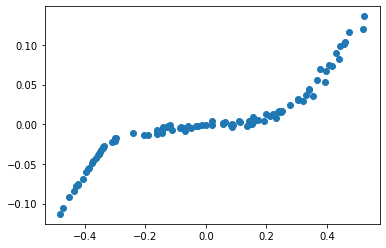

In [50]:
plt.scatter(fake_x[:,0], fake_x[:,1])

In [56]:
import os 

path = os.getcwd()
path = os.path.join(path + '/saved_simple_generator')

g_model.save(path)

INFO:tensorflow:Assets written to: /home/mikiu/Documents/git_projects/gan/saved_simple_generator/assets
